# LSTM RNN Model

## Recurrent Neural Network (RNN) and Long Short Time Memory (LSTM) model

## Environment set up

It is important that you have installed the required software and packages. Please have the following prerequisite ready before you run this notebook. 
- [Python 3.5.X](https://www.python.org/downloads/)
- [Keras](https://keras.io/)
- [Tensorflow](https://www.tensorflow.org/install/)

I choose these tools to implmenting the LSTM RNN because when I research this topic online, I have found a lot of related examples by using these set of tools which I can follow and get it work quickly.

## Load Library and Data


In [1]:
import numpy as np
np.random.seed(1337)
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Activation
from keras import optimizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint

c:\users\lahulsta\appdata\local\continuum\anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load a subset of the dataset
data = pd.read_csv('../../Data/dataset.csv', sep=',',  engine='python', nrows=1000000)

In [17]:
# Define key parameters
window = 640
steps = 4
horizon = 60
val_ratio = 0.8
scaling = 'standard' # standard, minmax, robust
target = 'absolute' # difference, absolute, log
log_transform = False
test_ratio = 0.8
batch_size=128

In [4]:
# Clean the data and sort by date
data['Timestamp UTC'] = pd.to_datetime(data['Timestamp UTC']) #, format='%Y-%m-%d')
data = data.sort_values(by=['Timestamp UTC'])

In [5]:
# Show the first data rows
data.head()

,Id,Timestamp UTC,Coker.Presion colector camara A,Coker.Presion colector camara B,Coker.Temperatura carga camara A,Coker.Temperatura carga camara B,Coker.Caudal GOL de Coker (Salida E-1207),Coker.Caudal reflujo fraccionadora,Coker.Presion DP plato 12 tope,Coker.Temperatura extraccion GOL,...,RC2AL2.Presion entrada,RC2AL2.Presion salida,RC2AL2.Ratio radial medio 1 vs axial,RC2AL2.Ratio radial superior vs axial,RC2AL2.WABT,Stripper C8.Caudal sulfhidrico masico,Stripper C8.Presion Stripper,Stripper C8.Temperatura diesel a Stripper,Stripper C8.Vapor a Stripper,Secado.Azufre
0,1,2013-01-11 13:49:46,2.167467,1.324405,475.8482,30.04991,29.9308,66.35257,1.015693,225.0837,...,62.25604,61.79222,20.31184,18.75264,384.0089,1.820098,0.230779,256.8568,2099.48,18.752520
1,2,2013-01-11 13:50:46,2.167467,1.324405,475.8482,30.04991,29.9308,67.73344,1.015693,226.4116,...,62.25604,61.79222,20.31184,18.75264,384.0089,1.820098,0.230779,256.8568,2099.48,18.761710
2,3,2013-01-11 13:51:46,2.167467,1.324405,475.8482,30.04991,29.9308,67.73344,1.015693,226.4116,...,62.25604,61.79222,36.62190,16.90409,384.2939,1.820098,0.230779,257.1349,2099.48,11.244150
3,4,2013-01-11 13:52:46,2.167467,1.324405,475.8482,30.04991,29.9308,67.73344,1.015693,226.4116,...,62.25604,61.79222,36.62190,16.90409,384.2939,1.820098,0.228053,257.1349,2099.48,11.234950
4,5,2013-01-11 13:53:46,2.167467,1.324405,475.8482,30.04991,29.9308,66.78139,1.015693,226.4116,...,62.25604,61.79222,36.62190,39.44015,384.2939,1.820098,0.228053,257.1349,2099.48,8.143267


In [6]:
# Determine feature characteristics
(data.describe())

,Id,Coker.Presion colector camara A,Coker.Presion colector camara B,Coker.Temperatura carga camara A,Coker.Temperatura carga camara B,Coker.Caudal GOL de Coker (Salida E-1207),Coker.Caudal reflujo fraccionadora,Coker.Presion DP plato 12 tope,Coker.Temperatura extraccion GOL,Crudo 1.Caudal diesel DA-103 a tanques,...,RC2AL2.Presion entrada,RC2AL2.Presion salida,RC2AL2.Ratio radial medio 1 vs axial,RC2AL2.Ratio radial superior vs axial,RC2AL2.WABT,Stripper C8.Caudal sulfhidrico masico,Stripper C8.Presion Stripper,Stripper C8.Temperatura diesel a Stripper,Stripper C8.Vapor a Stripper,Secado.Azufre
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,1.631907,1.618618,272.805390,271.975558,20.648238,46.954307,0.836213,198.636578,53.299417,...,61.124384,59.689258,39.243011,32.101349,361.638013,1.333995,0.249237,262.845133,2242.547503,6.839054
std,288675.278932,0.985945,0.998411,197.982111,197.894888,6.122360,18.486597,0.275402,55.261510,41.142852,...,2.846960,2.733837,60.404164,35.789226,26.114503,1.201860,0.031381,13.267204,599.797699,3.481921
min,1.000000,-0.056394,-0.239817,-172.082900,-195.239300,0.824763,-4.120764,-0.038949,-0.003238,0.000000,...,-0.899243,-0.870846,-5404.701000,-3696.481000,39.030260,-0.001371,-0.100000,25.285120,0.000000,-0.009201
25%,250000.750000,0.993127,1.046423,40.612610,40.811130,18.014620,41.092990,0.771034,206.845200,0.566985,...,60.107320,58.857850,22.561210,22.010560,346.717400,0.946958,0.237593,259.777500,1802.746000,4.536304
50%,500000.500000,1.956132,1.891158,266.449300,264.785350,22.000270,50.376890,0.874645,214.894800,72.637600,...,61.366260,59.936940,30.771970,28.047020,357.288000,1.244442,0.249968,264.005600,2223.963000,6.680238
75%,750000.250000,2.192579,2.139555,473.434900,472.940000,25.009930,57.792722,0.989223,220.926100,90.817500,...,62.483220,60.826720,52.387700,39.399840,384.721300,1.608402,0.260895,267.732900,2602.635000,8.630940
max,1000000.000000,6.003400,6.002831,900.110000,900.713600,46.099780,110.065300,3.905464,400.604900,128.432100,...,66.600810,64.631940,15600.060000,7886.351000,410.473300,22.274940,1.100000,303.783000,4200.478000,29.895450


In [7]:
data = data.drop(['Timestamp UTC' ,'Id'], axis=1)

In [8]:
data = data.dropna(axis=0, how='any')

In [31]:
#Scale the data and drop the timestamp/id/... (non-feature)
# apply different scalers
diff = np.zeros(len(data[['Secado.Azufre']]))
diff[horizon:] = np.squeeze(data[['Secado.Azufre']].values[horizon:]-data[['Secado.Azufre']].values[0:len(data[['Secado.Azufre']])-horizon])
data['Secado.Azufre.Diff'] = diff
if log_transform:
        data['Secado.Azufre.Log'] = np.log(np.absolute(data[['Secado.Azufre']]+0.001))

if scaling is 'standard':
    scaler = StandardScaler()
elif scaling is 'minmax':
    scaler = MinMaxScaler()
elif scaling is 'robust':
    scaler = RobustScaler()
data_ = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
if target is 'difference':
    df_Y = data_[['Secado.Azufre.Diff']]
elif target is 'absolute' and log_transform:
    df_Y = data_[['Secado.Azufre.Log']]
elif  target is 'absolute':
    df_Y = data_[['Secado.Azufre']]
df_X = data_

In [18]:
X = np.array(df_X.values)
y = np.array(df_Y.values)
X = X[:len(X)-horizon]
y = y[horizon:]
print(len(X), len(y))
X_train, y_train = X[0:int(len(X)*val_ratio)], y[0:int(len(y)*val_ratio)]
X_val, y_val = X[int(len(X)*val_ratio):], y[int(len(y)*val_ratio):]
print(len(y_train), len(y_val))

981036 981036
784828 196208


In [34]:
train_generator = TimeseriesGenerator(X_train , y_train, length=window, sampling_rate=steps, stride=3, start_index=0, end_index=None, shuffle=True, reverse=False, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val , y_val, length=window, sampling_rate=steps, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=batch_size)

In [35]:
# create and fit the LSTM network
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(int(window/steps),X_train.shape[1]),)) 
model.add(LSTM(64, return_sequences=False, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(1)) 
rms = optimizers.RMSprop(lr=0.0001)
model.compile(loss='mean_squared_error', optimizer=rms)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 160, 64)           6720      
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 39,809
Trainable params: 39,809
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
mc_callback = ModelCheckpoint('model.pkl', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit_generator(train_generator, validation_data=val_generator, epochs=100, shuffle=True, steps_per_epoch=500, validation_steps=500, callbacks=[mc_callback])

Epoch 1/100
500/500 [==============================] - 343s 685ms/step - loss: 0.8782 - val_loss: 0.9423
Epoch 2/100
500/500 [==============================] - 373s 745ms/step - loss: 0.7451 - val_loss: 0.9063
Epoch 3/100
500/500 [==============================] - 451s 903ms/step - loss: 0.6794 - val_loss: 0.8933
Epoch 4/100
500/500 [==============================] - 443s 886ms/step - loss: 0.6403 - val_loss: 0.8573
Epoch 5/100
500/500 [==============================] - 548s 1s/step - loss: 0.6029 - val_loss: 0.8474
Epoch 6/100
279/500 [===============>..............] - ETA: 3:05 - loss: 0.5780

KeyboardInterrupt: 

In [36]:
model.load_weights('model.pkl')
y_pred = model.predict_generator(val_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)

1528/1528 [==============================] - 316s 206ms/step


In [42]:
# invert predictions
diff = len(y_val)-len(y_pred)
print(diff, len(y_val), len(y_pred))
X_val_pred = np.zeros((len(y_pred), X_train.shape[1]+2, ))
X_val_pred[:,-1] = list(y_pred)
y_pred_scaled = scaler.inverse_transform(X_val_pred)[:,-1]
X_val_ = np.zeros((len(y_val), X_train.shape[1]+2, ))
X_val_[:,-1] = list(y_val)
y_val_scaled = scaler.inverse_transform(X_val_)[:,-1]
if log_transform:
    y_pred_scaled = np.exp(y_pred_scaled)
    y_val_scaled = np.exp(y_val_scaled)
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(y_val_scaled[window:][0:len(y_pred_scaled)], y_pred_scaled))
print('Test Score: %.2f RMSE' % (testScore)) 

641 196208 195567
Test Score: 1.64 RMSE


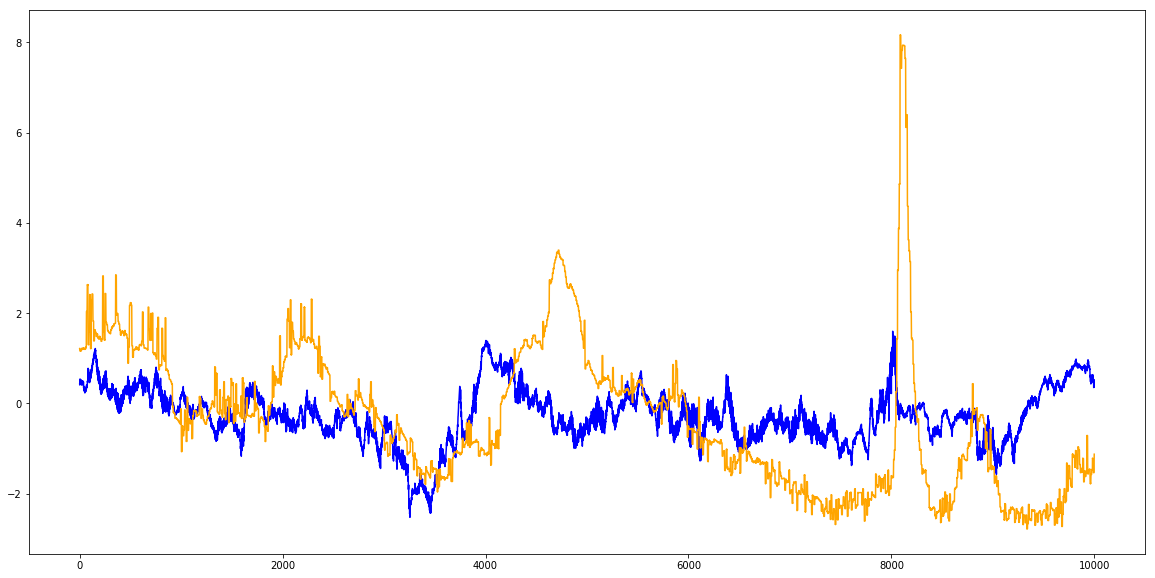

In [43]:
start, end = 10000, 20000
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(y_pred_scaled[start:end], color='blue')
plt.plot(y_val_scaled[window:][0:len(y_pred_scaled)][start:end], color='orange')

In [44]:
real = y_val_scaled[window:][0:len(y_pred_scaled)][0:50000]
pred = y_pred_scaled[0:50000]
df = pd.DataFrame({'real':real, 'pred':pred})
df.to_csv('model_results_timehorizon_60_nosulphur.csv', index=True) 

In [120]:
# summarize history for loss
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

<Figure size 1440x720 with 0 Axes>

0.025194997763648697


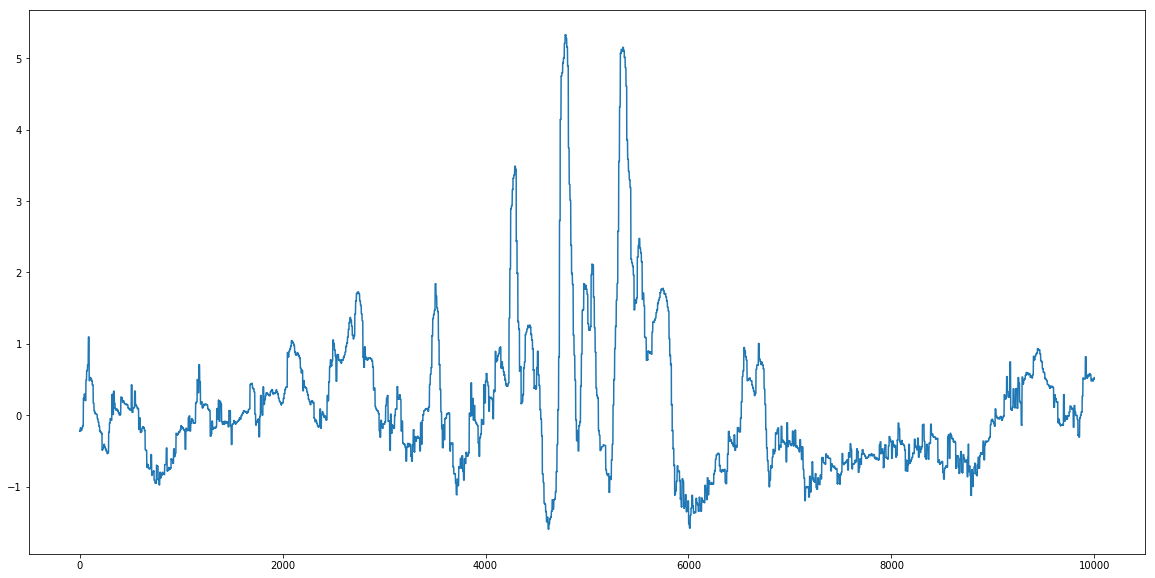

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(y_train[0:10000])
print(np.mean(y_train))

-0.0015739646989385433


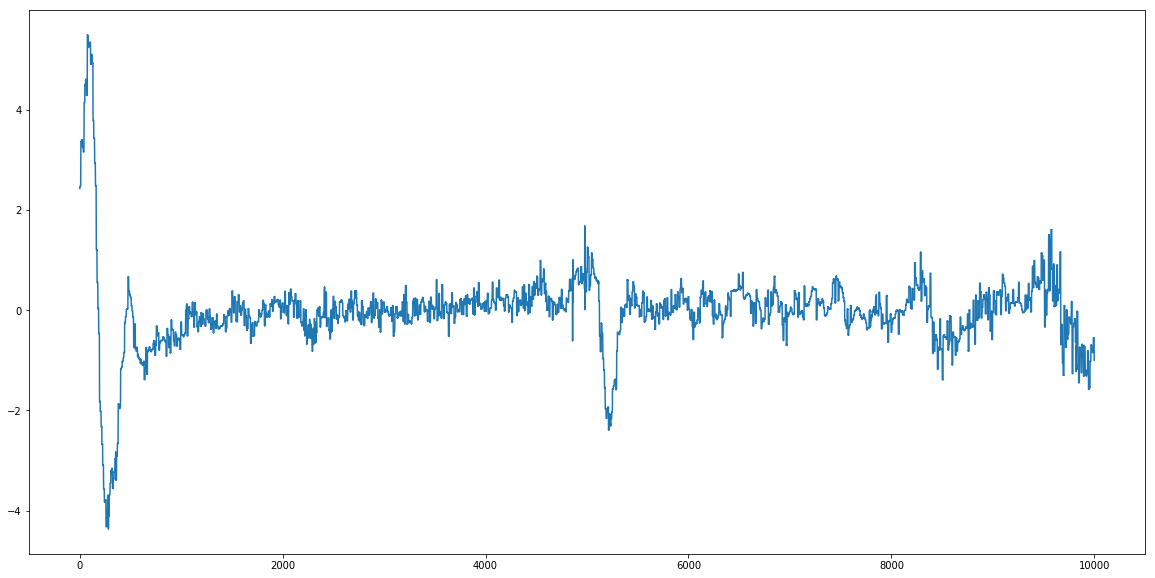

In [104]:
plt.figure(figsize=(20,10))
plt.plot(y_val[0:10000])
print(np.mean(y_val))

In [105]:
np.min(y_train)

-10.586622708165049

In [24]:
df_X.columns.values

array(['Coker.Presion colector camara A',
       'Coker.Presion colector camara B',
       'Coker.Temperatura carga camara A',
       'Coker.Temperatura carga camara B',
       'Coker.Caudal GOL de Coker (Salida E-1207)',
       'Coker.Caudal reflujo fraccionadora',
       'Coker.Presion DP plato 12 tope',
       'Coker.Temperatura extraccion GOL',
       'Crudo 1.Caudal diesel DA-103 a tanques',
       'Crudo 1.Presion filtros FD-101/102',
       'Crudo 1.Presion tope de torre DA-101',
       'Crudo 1.Temperatura salida C.R. de DA-101',
       'Crudo 2.Caudal gasoil a tanque',
       'Crudo 2.Temperatura entrada zona flash torre',
       'Crudo 2.Temperatura fondo torre de crudo',
       'Crudo 2.Temperatura liquido a recipiente overflash',
       'FCC/URG3.Caudal aceite pobre absorb secundario',
       'FCC/URG3.S carga FCC', 'FCC/URG3.Temperatura vapor a plato LCO',
       'Entrada de LÃ\xadquido.Caudal',
       'Entrada de LÃ\xadquido.Porcentaje de Azufre en la entrada de HDS2',
  

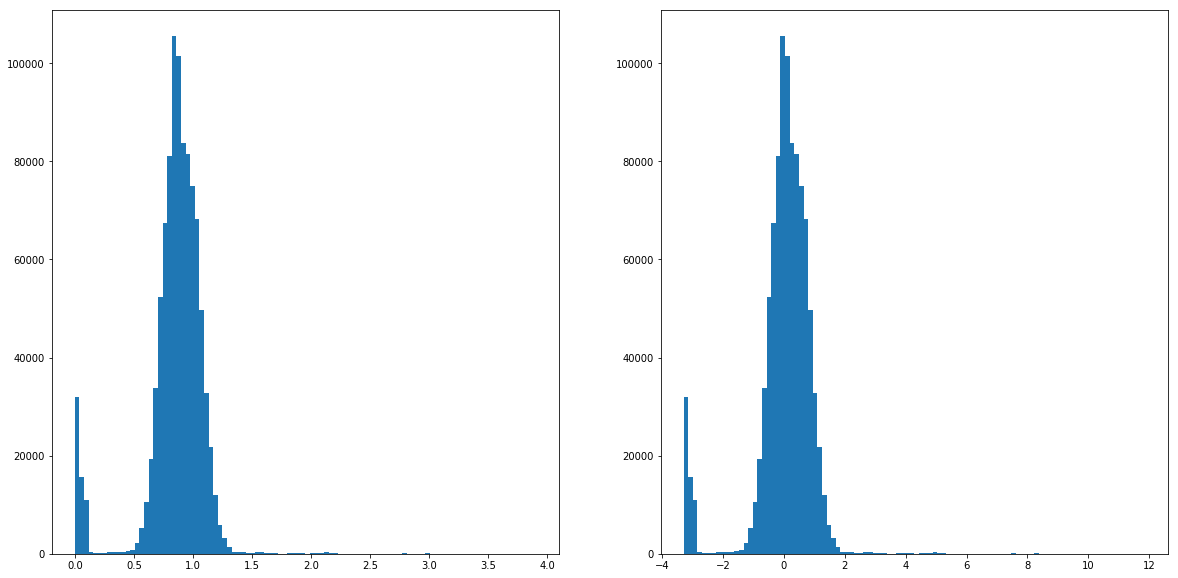

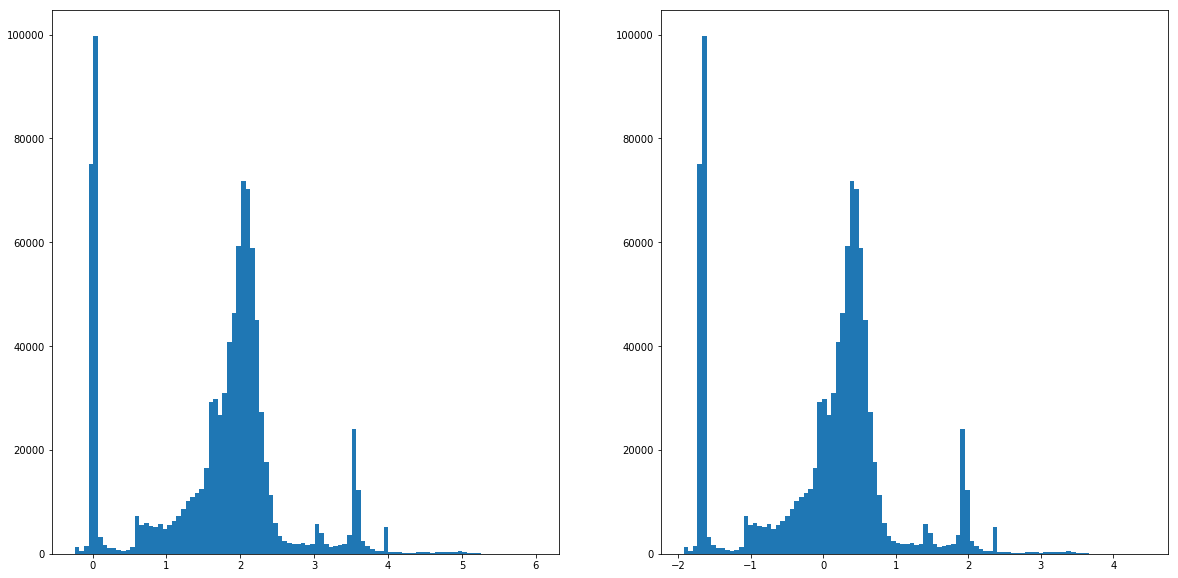

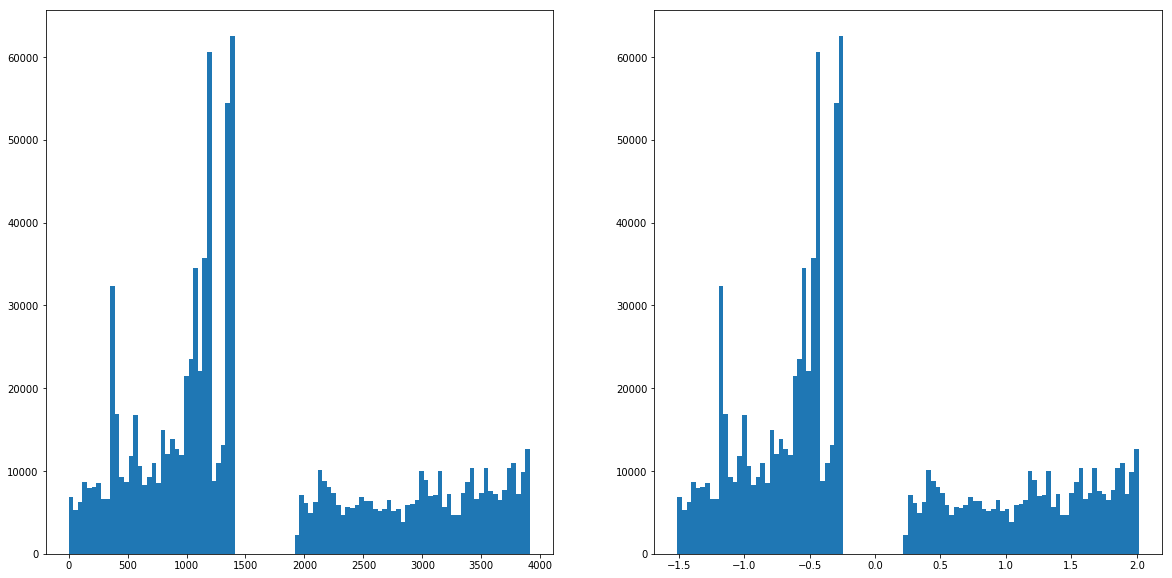

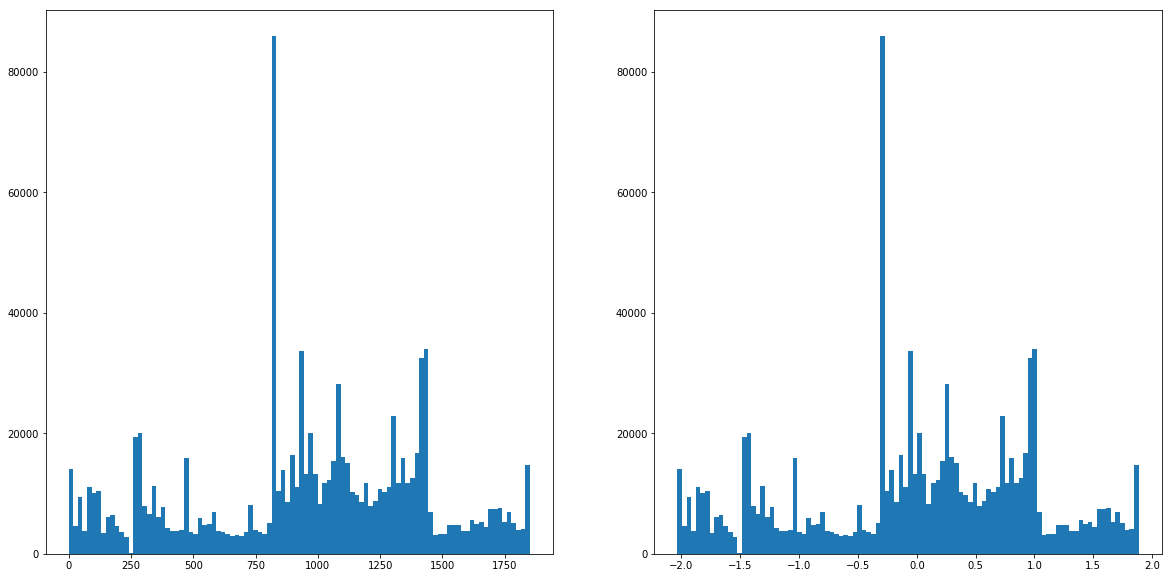

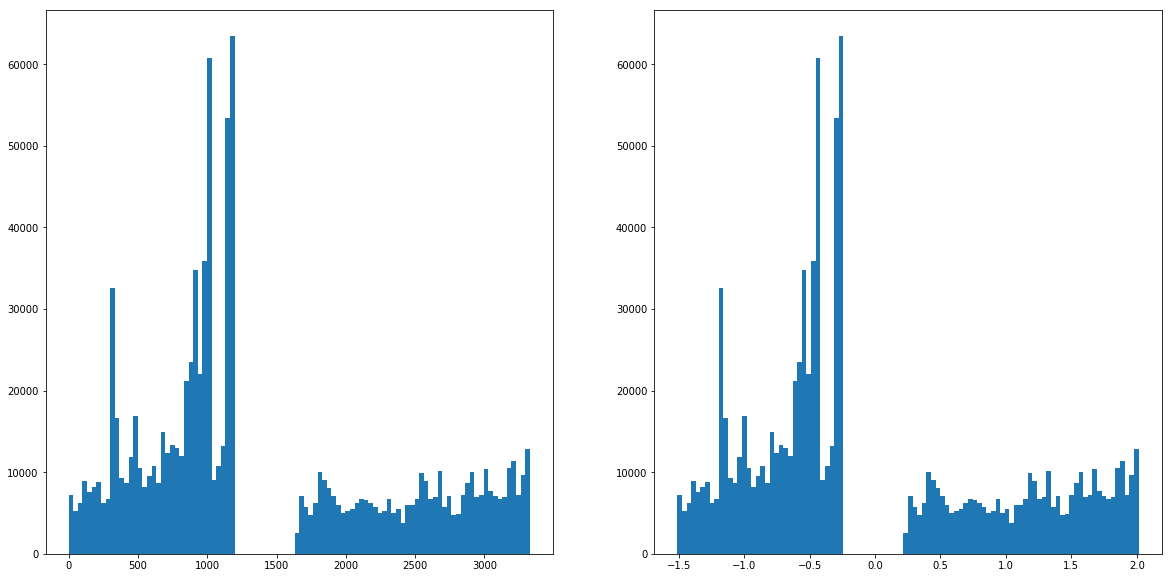

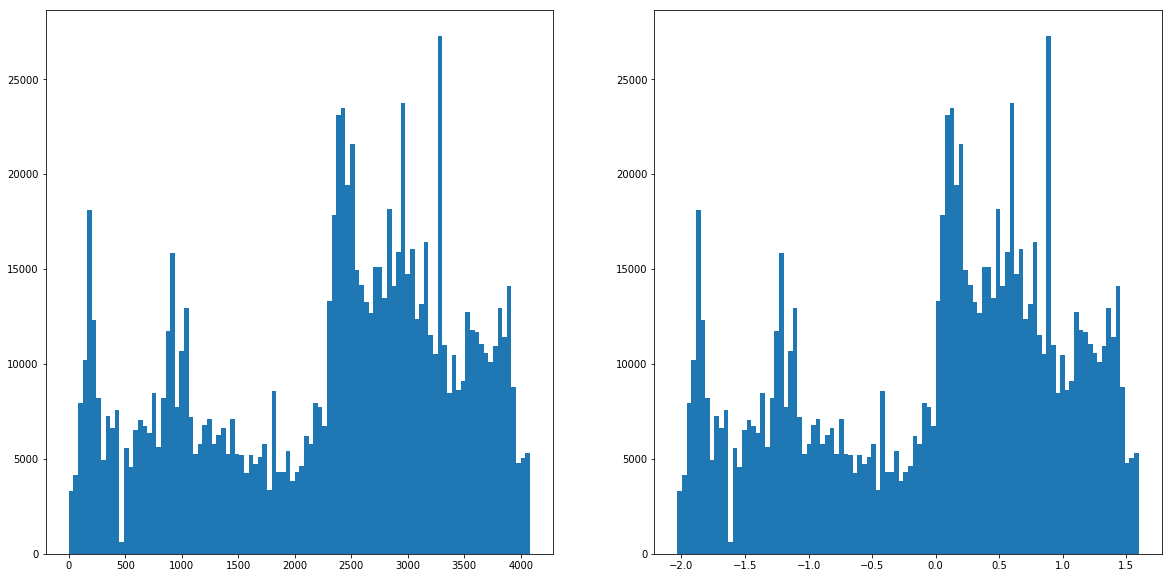

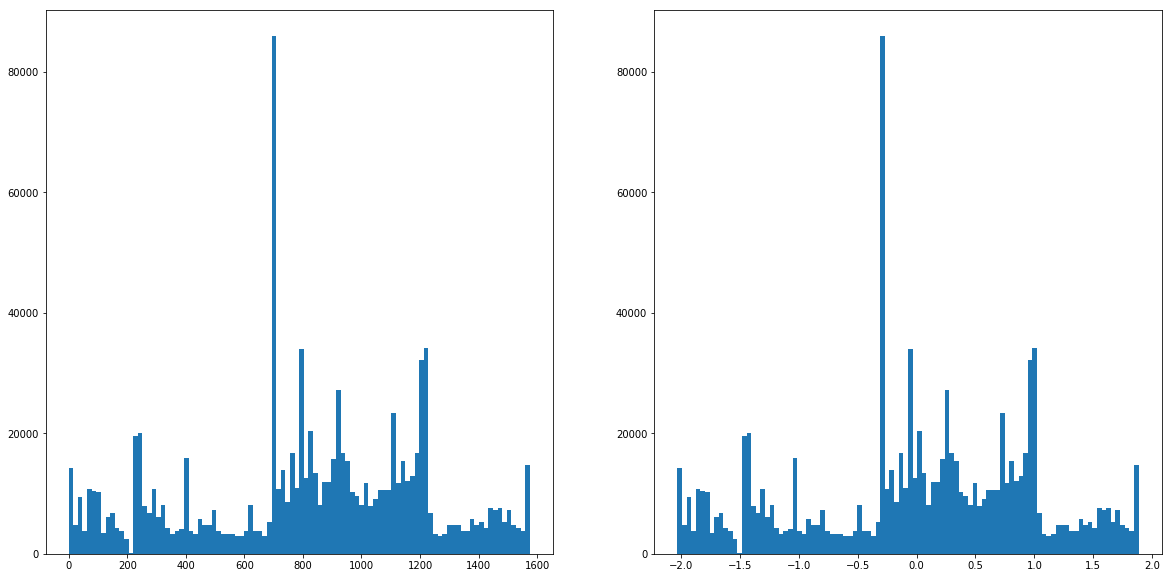

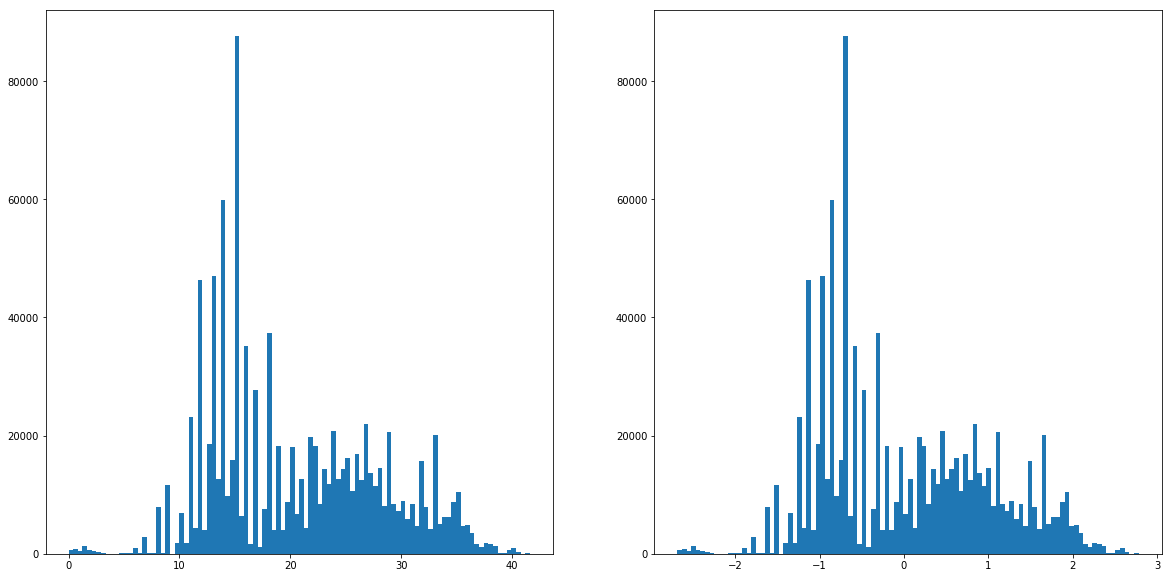

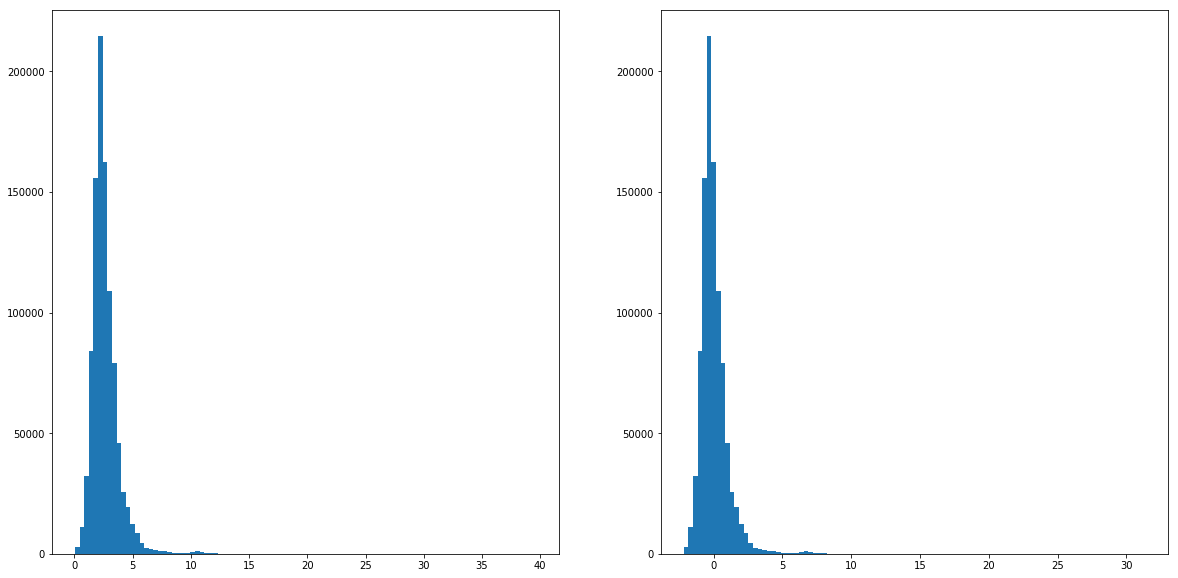

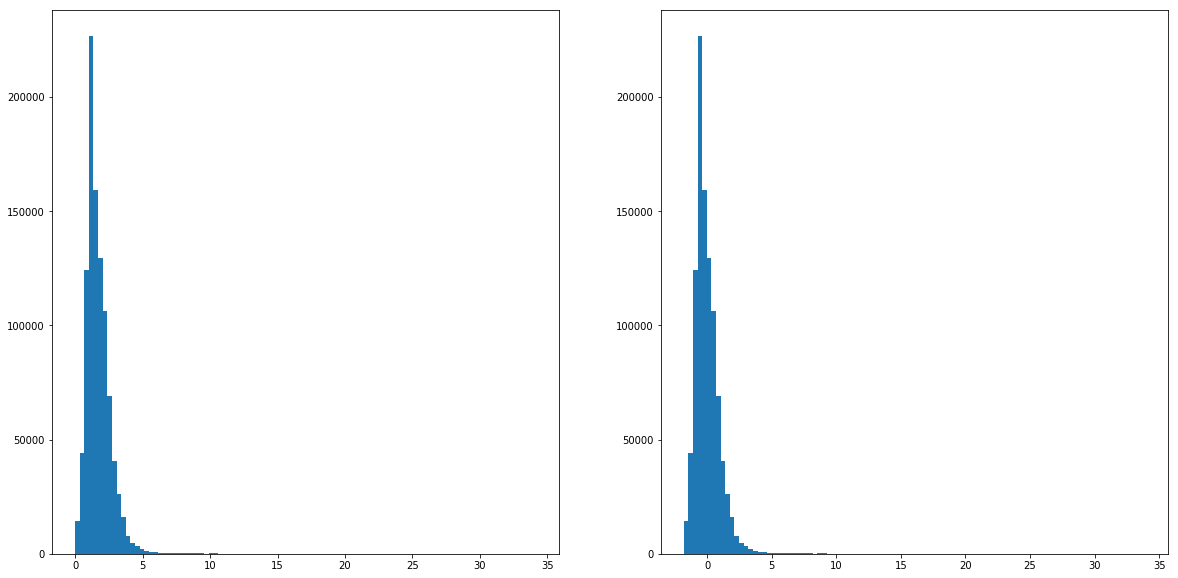

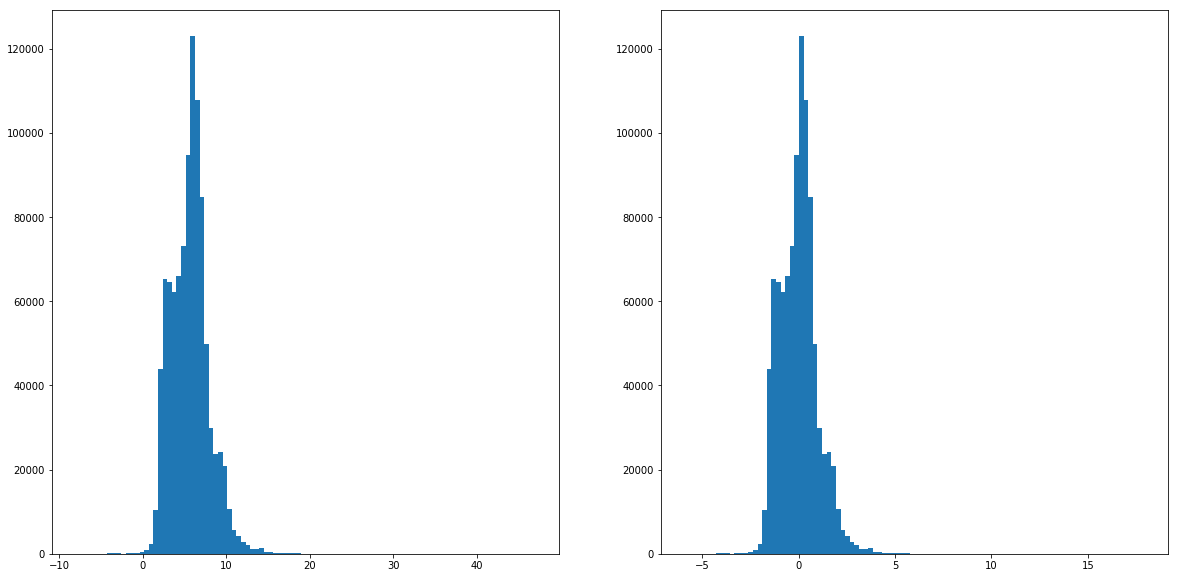

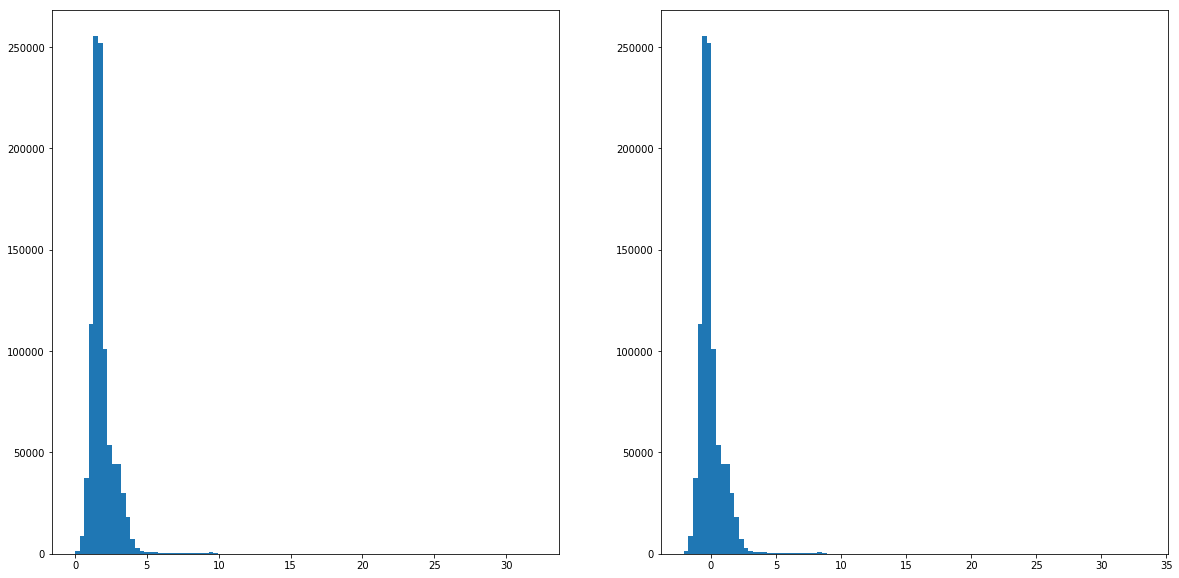

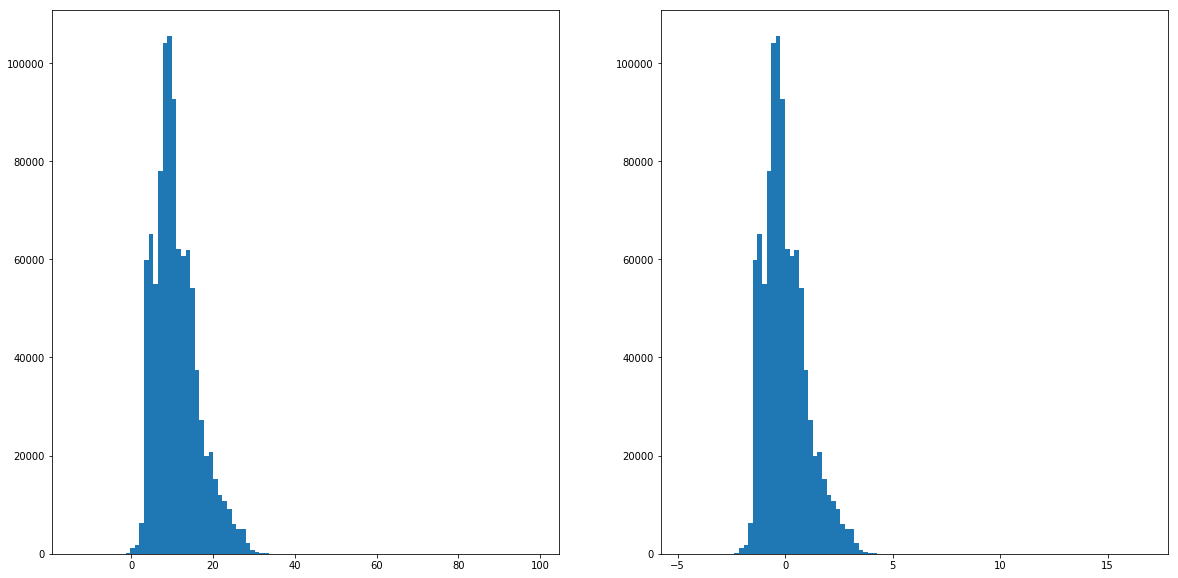

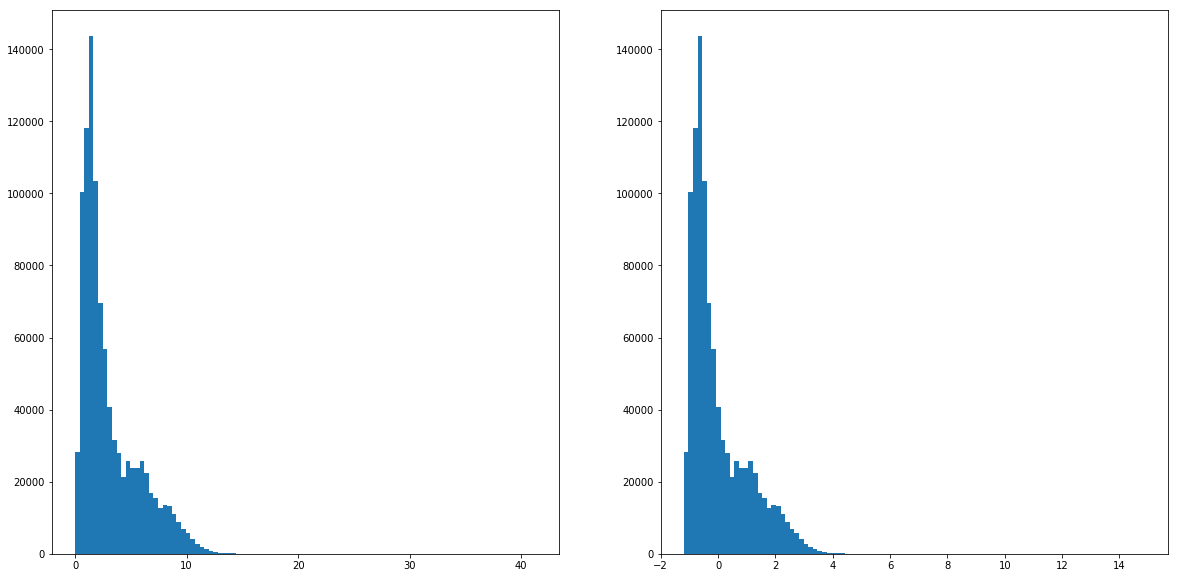

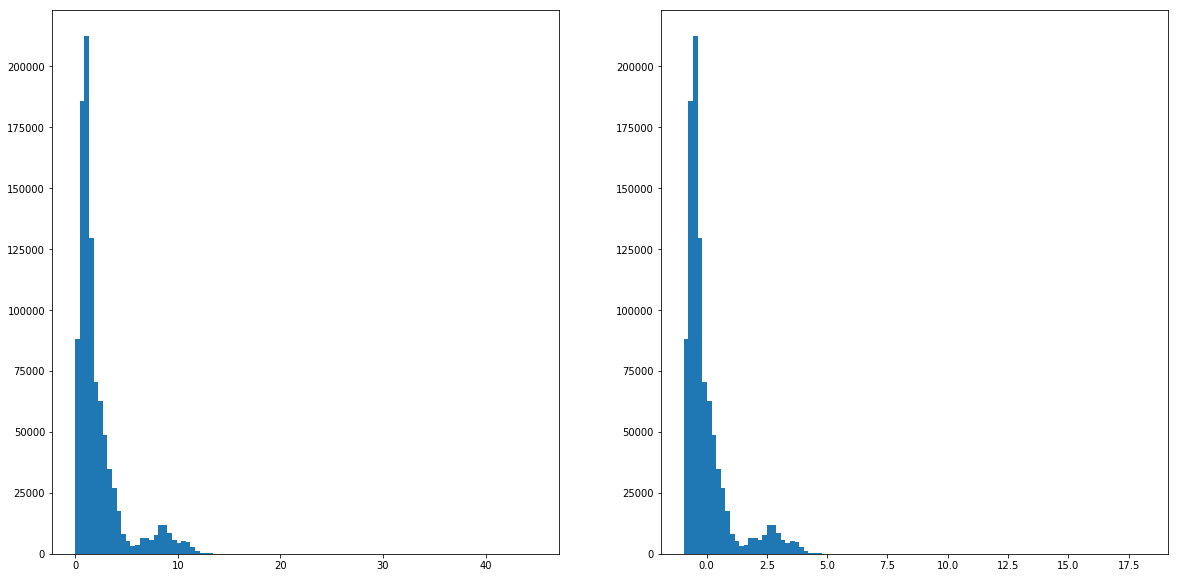

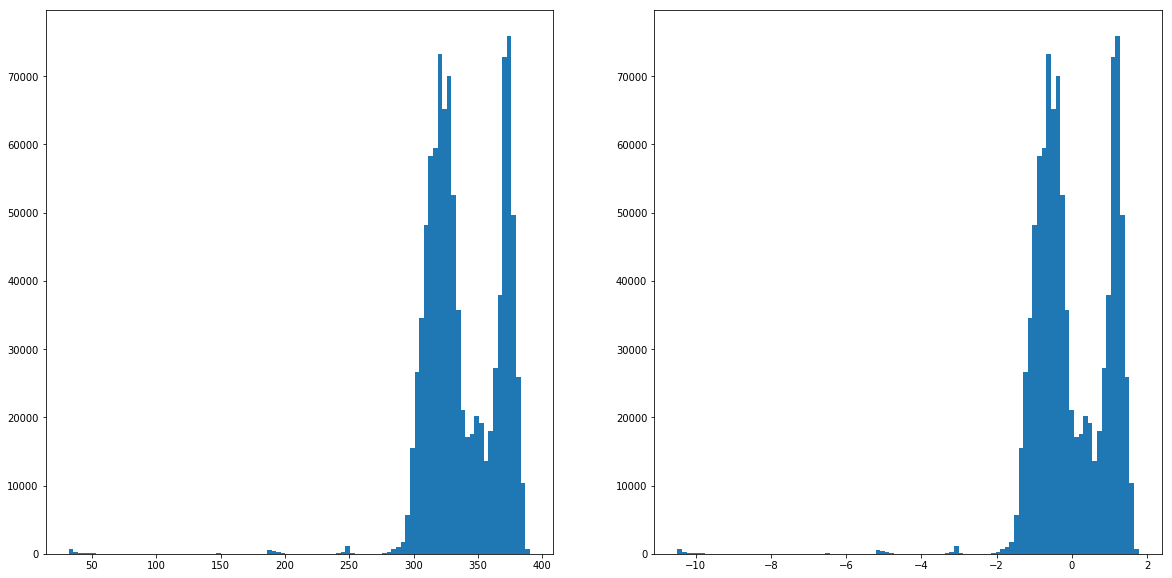

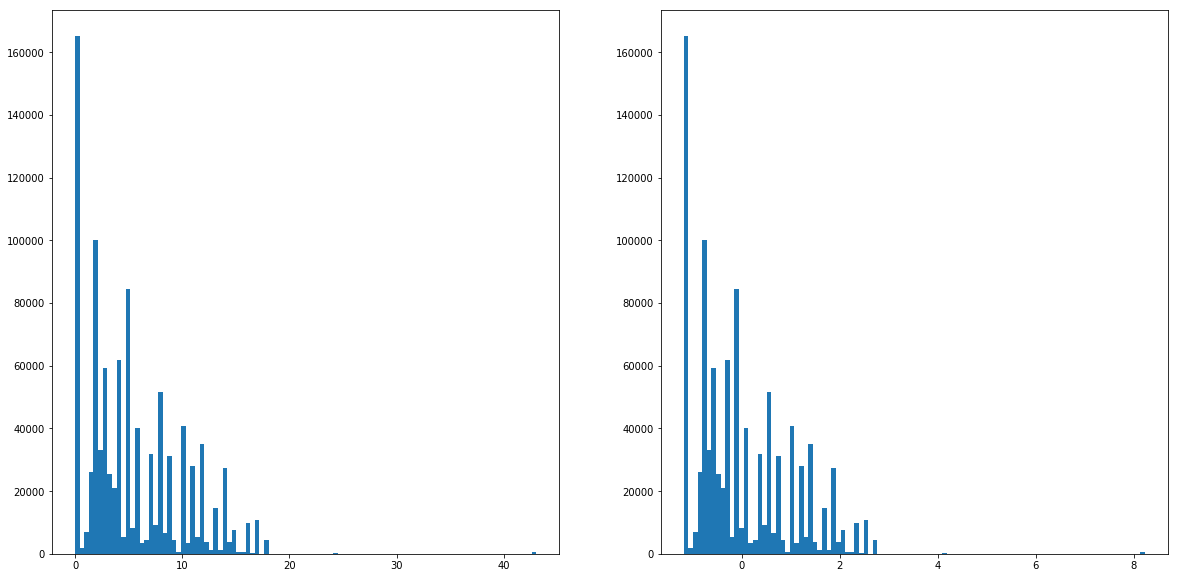

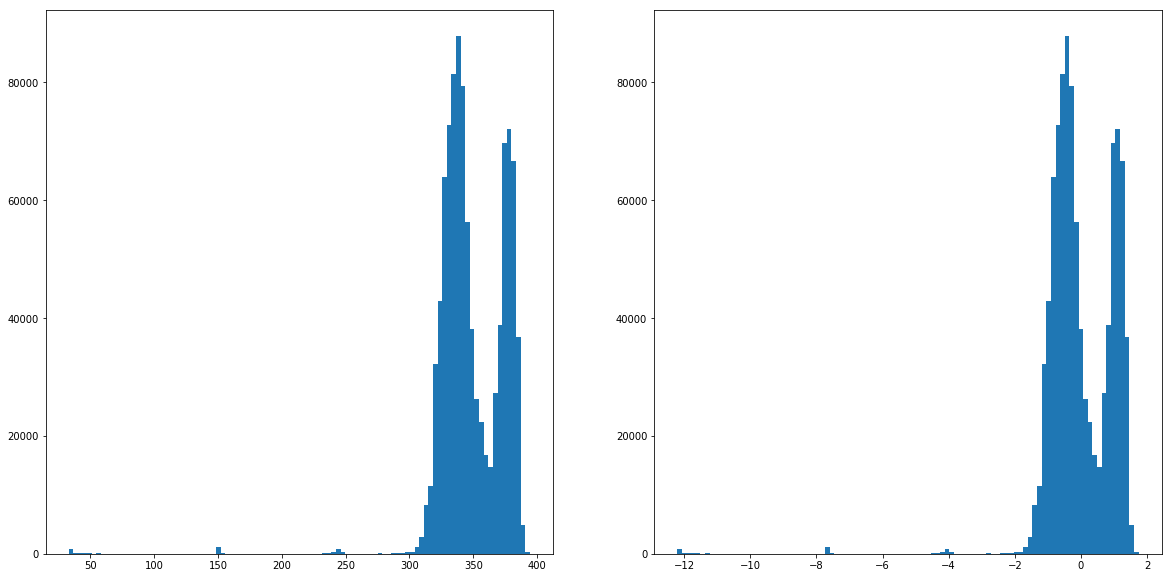

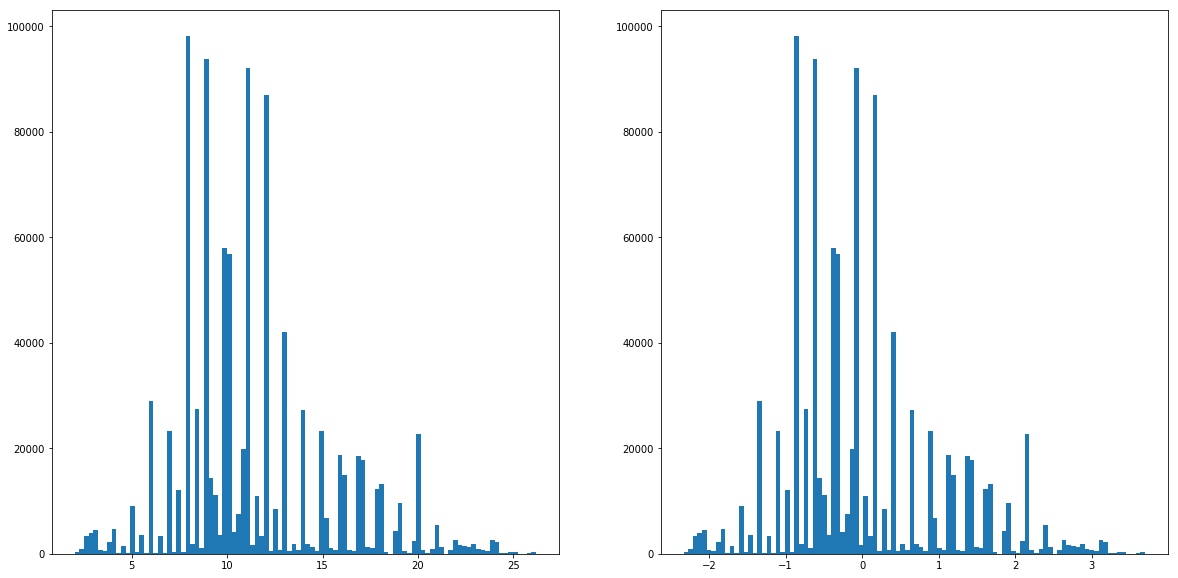

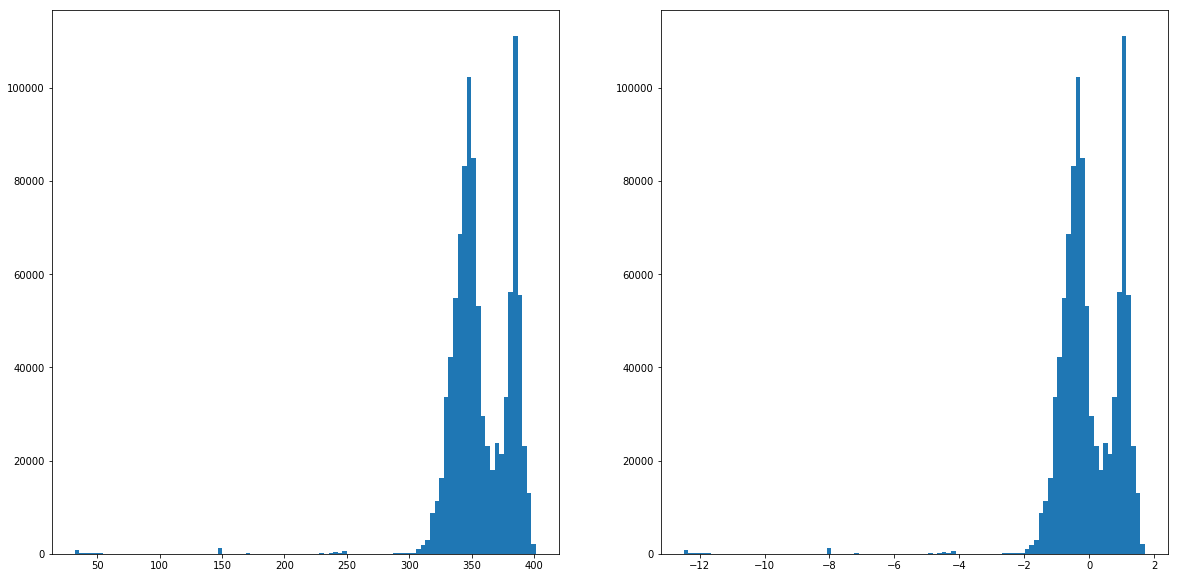

In [51]:
for var in variables:
    if var in df_X.columns.values:
        plt.figure(figsize=(20,10))
        plt.subplot(1, 2, 1)
        plt.hist(data[var].values, bins=100)
        plt.subplot(1, 2, 2)
        plt.hist(data_[var].values, bins=100)

-0.009201467 29.89545


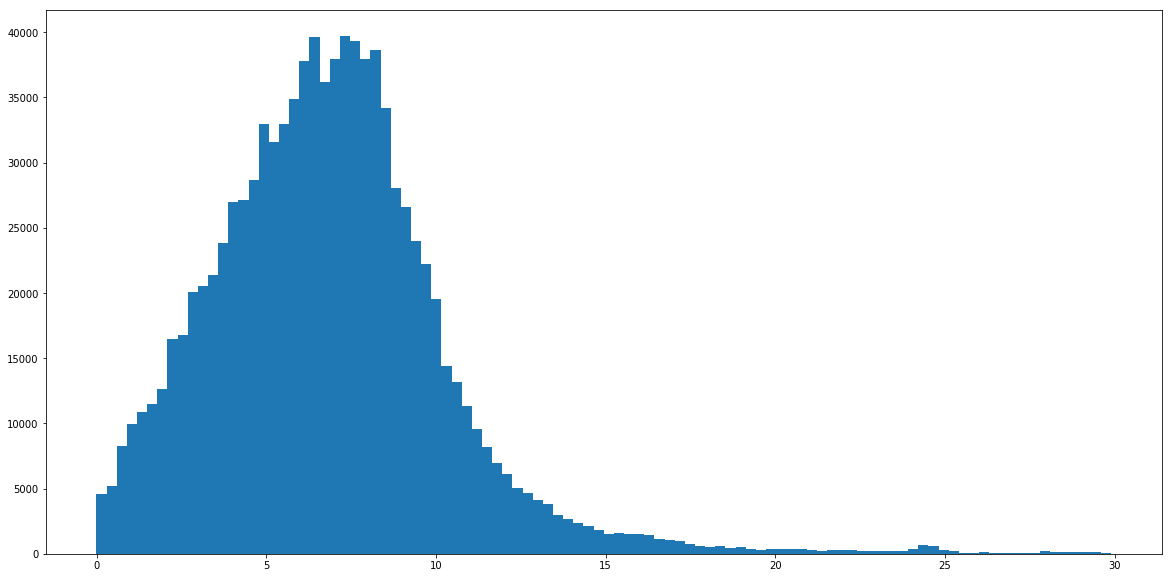

In [122]:
plt.figure(figsize=(20,10))
_= plt.hist(data['Secado.Azufre'], bins=100)
print(np.min(data['Secado.Azufre']), np.max(data['Secado.Azufre']))

-1.9778699990245912 6.638556789773057


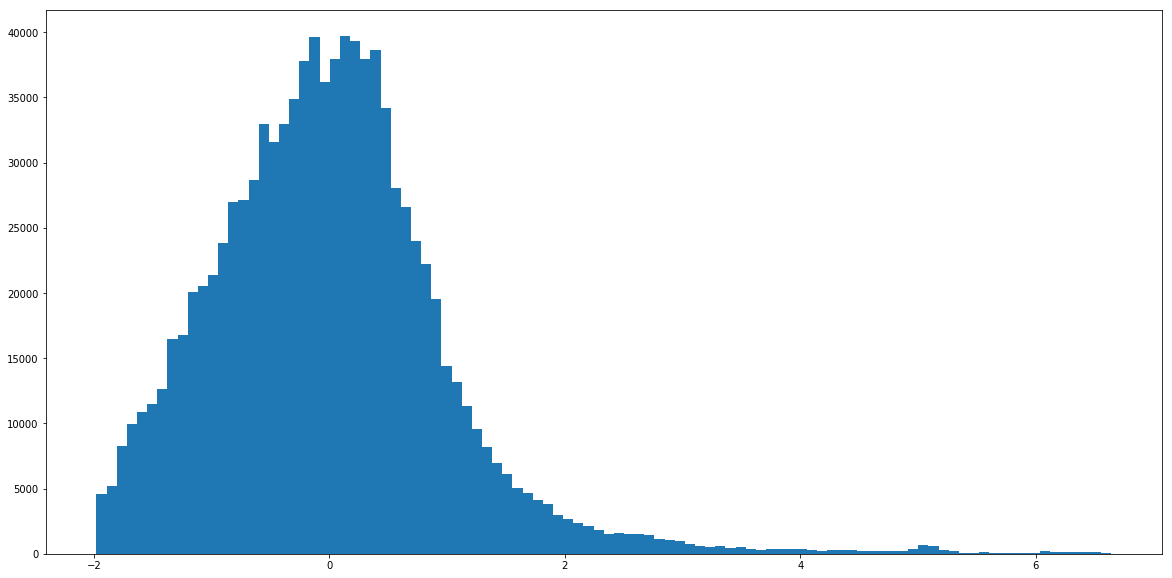

In [12]:
plt.figure(figsize=(20,10))
_= plt.hist(data_['Secado.Azufre'], bins=100)
print(np.min(data_['Secado.Azufre']), np.max(data_['Secado.Azufre']))

Secado.Azufre   -1.97787
dtype: float64 Secado.Azufre    6.638557
dtype: float64


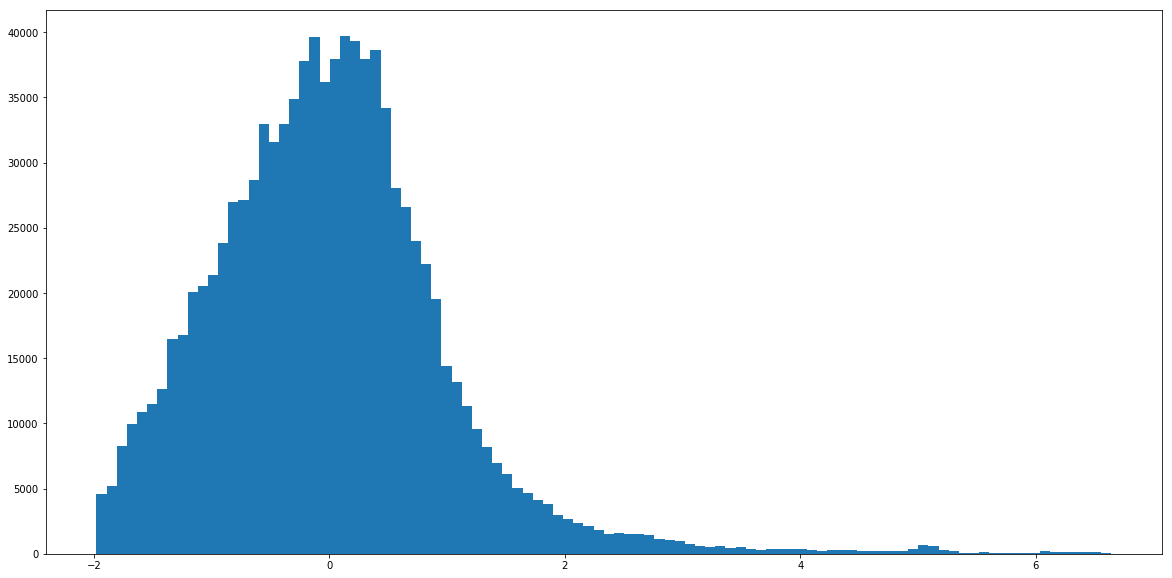

In [123]:
plt.figure(figsize=(20,10))
_= plt.hist(df_Y.values, bins=100)
print(np.min(df_Y), np.max(df_Y))

Secado.Azufre   -1.97787
dtype: float64 Secado.Azufre    6.638557
dtype: float64


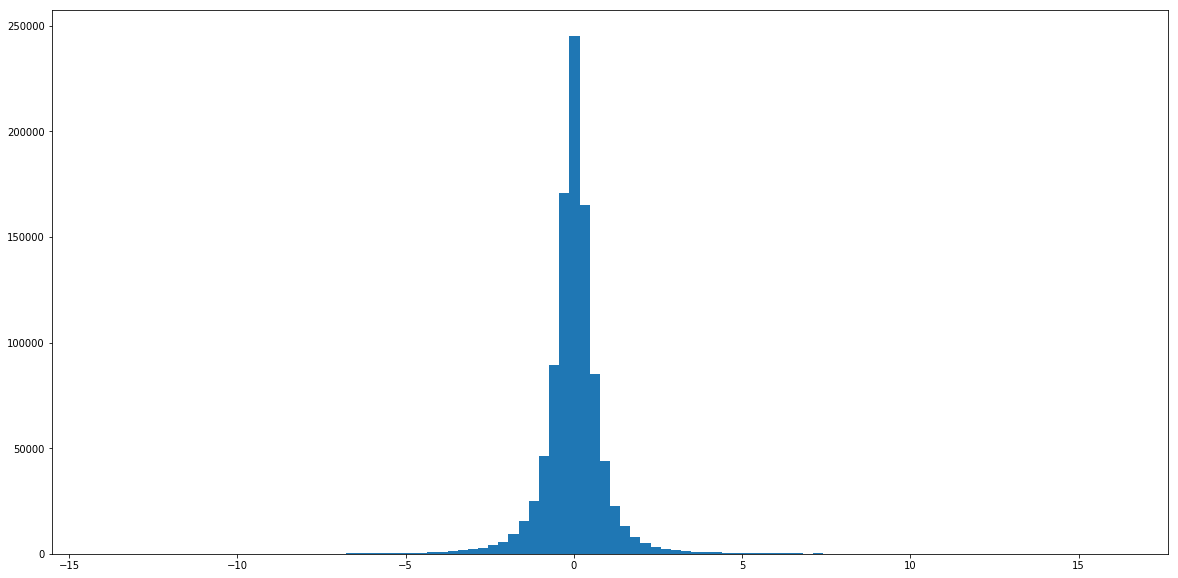

In [124]:
plt.figure(figsize=(20,10))
_= plt.hist(df_X['Secado.Azufre.Diff'].values, bins=100)
print(np.min(df_Y), np.max(df_Y))
